* This notebook was made to evaluate mean current (only forced by river flow) during low river flow period by comparing with codar data.

In [1]:
%matplotlib inline
from IPython.core.display import Image,display
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import datetime
from salishsea_tools import (viz_tools,tidetools,nc_tools,stormtools)
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import os
import glob
import codar
stations = {'Westshore': {'lat': 49.018,'lon': -123.1719},
            'Iona':{'lat': 49.2159, 'lon': -123.2054}}
bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)

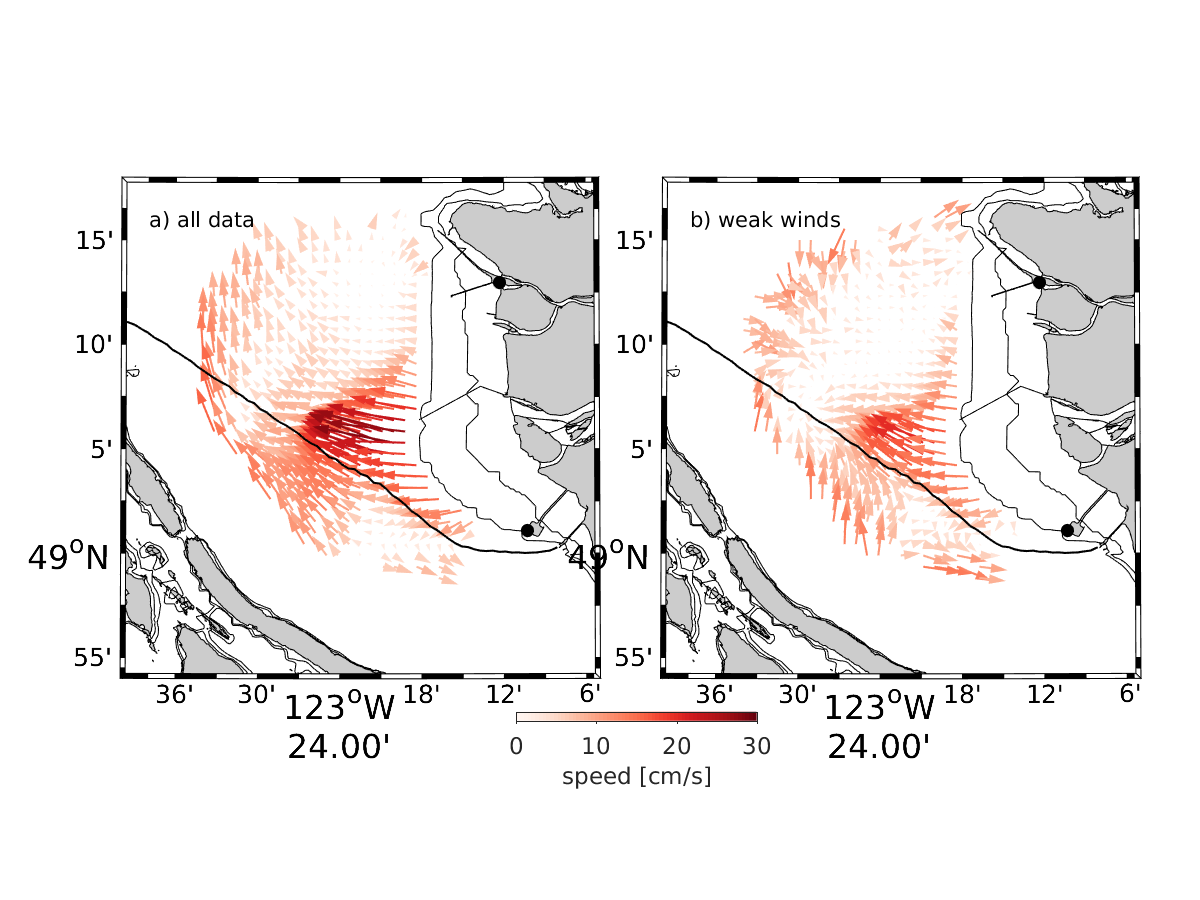

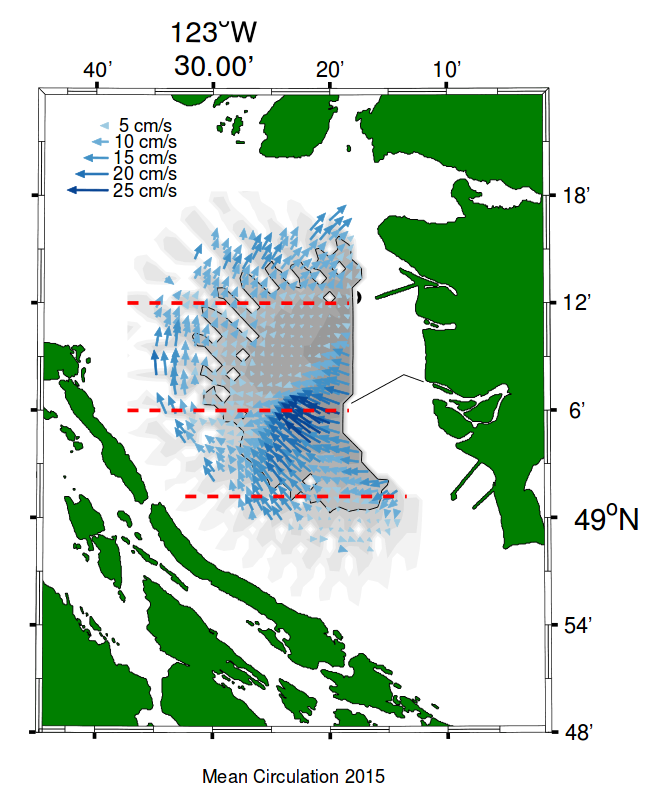

In [2]:
x = Image(filename='/ocean/jieliu/research/meopar/surface current/average_CODAR_Sep_Oct_2014.png')
y = Image(filename='/ocean/jieliu/research/meopar/surface current/mean_currents_CODAR_2015.png')
display(x, y)

In [3]:
## load data
codar_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/SoG_radar_totals.mat')
t = codar_data['mtime']
lat_codar = codar_data['glat']
lon_codar = codar_data['glon']
u = codar_data['u']
v = codar_data['v']
## load radial data
iona_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/ionaRadialGrid.mat')
west_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/westRadialGrid')

In [4]:
## load different bathys
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X={};Y={};bathy={};grids = [grid2,grid6]
for grid in grids:
    X[grid] = grid.variables['nav_lon'][:, :]
    Y[grid] = grid.variables['nav_lat'][:, :]
    bathy[grid] = grid.variables['Bathymetry'][:, :]
## load grid6 model result
uv_all = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/OctMeanCurrent/codar_all_large.nc'); 

# Research Questions:

* 1) During which time period would i like to take a look at the mean river flow of model results? For a month, a week??
* 2) Based on the all data and weak wind case, should I also average over the same period as what I did for the codar data? Or use the same mean current of the codar data? The essence is that what does "mean current" mean in my case? Should I make them in the same period?
* 3) By evaluating the mean current field of model result, I hope to get some insights about explaining the mouth region is saltier in the long river simulation. I don't know if this might help or not...

In [5]:
run_low = datetime.datetime(2015,10,1,0);
run_up = datetime.datetime(2015,11,1,0);

In [6]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)

In [7]:
def load_uv_grid6(u_new,v_new,u_m, v_m, U_m,V_m,lon,lat,ax2,cmin=0,cmax = 0.1 ):
    """This function was made to load, read u and v of bathy6 results, calculate
    mean u, v current"""
    u_6 = uv_all.variables['vozocrtx']
    v_6 = uv_all.variables['vomecrty']
    u_mean6 = np.nanmean(u_6, axis = 0)
    v_mean6 = np.nanmean(v_6, axis = 0)

    u_m[grid6] =u_mean6[0,:,:]
    v_m[grid6] =v_mean6[0,:,:]
    ##unstagger u v
    U_m[grid6],V_m[grid6] = viz_tools.unstagger(u_m[grid6],v_m[grid6])
    #rotate
    theta = np.pi*29/180
    U_m[grid6] = U_m[grid6]*np.cos(theta) - V_m[grid6]*np.sin(theta)
    V_m[grid6] = U_m[grid6]*np.sin(theta) +V_m[grid6]*np.cos(theta)
    ##mask
    U_m[grid6]=np.ma.masked_values(U_m[grid6],0)
    V_m[grid6]=np.ma.masked_values(V_m[grid6],0)

    lon[grid6] = X[grid6][380:479,240:319]
    lat[grid6] = Y[grid6][380:479,240:319]
    ## select codar domain
    u_m6, v_m6 = mask_ModelResult(u_new,v_new,X[grid6],Y[grid6],bathy[grid6],U_m[grid6],V_m[grid6], flag = 'grid6')
    mesh=ax2.pcolormesh(lon[grid6], lat[grid6], \
            np.sqrt(u_m6**2+v_m6**2), cmap='Reds', vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax2)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax2.quiver(lon[grid6], lat[grid6], u_m6[:,:], v_m6[:,:],\
                        pivot='mid',scale=2,width=0.005, color='black')
    ax2.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax2,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax2, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    return ax2

In [8]:
def mask_ModelResult(u_new,v_new,X,Y,bathy,U_m,V_m,flag = 'grid2'):
    """This function is to mask the model result outside codar domain """
    i_ind = [] ## mask indices to apply for a model result
    j_ind= []
    mm = ma.masked_invalid(np.sqrt(u_new**2+v_new**2))
    U_m_new = np.copy(U_m) ## set up new U_m and V_m array for applying the mask
    U_m_new = ma.array(U_m_new, mask =True)
    V_m_new = np.copy(V_m)
    V_m_new = ma.array(V_m_new, mask =True)
    for j in range(46):
        for i in range(36):
            if mm[j,i] != 1e+20:
                [jj,ii] = tidetools.find_closest_model_point(lon_codar[j,i],lat_codar[j,i],\
                            X,Y,bathy,lat_tol=0.0021)
                if flag == 'grid2':
                    j_ind.append(jj)
                    i_ind.append(ii)
                elif flag =='grid6':
                    jj = jj - 380 ## start j of the subdomain in grid6
                    ii = ii - 240## start i of the subdomain in grid6
                    j_ind.append(jj)
                    i_ind.append(ii)
    j_inds = np.array(j_ind)
    i_inds = np.array(i_ind)

    if flag == 'grid2':
        for j in np.arange(481,380,-1):
            for i in np.arange(240,330,1):
                for k in range (len(j_inds)):
                    if (j == j_inds[k]) and (i== i_inds[k]):         
                        U_m_new[j,i] = U_m[j,i]
                        V_m_new[j,i] = V_m[j,i]
    elif flag =='grid6':
        for j in np.arange(99,-1,-1):
            for i in np.arange(0,80,1):
                for k in range (len(j_inds)):
                    if (j == j_inds[k]) and (i== i_inds[k]):         
                        U_m_new[j,i] = U_m[j,i]
                        V_m_new[j,i] = V_m[j,i]
    return U_m_new, V_m_new

In [12]:
def plot_both(run_low,run_up,cmin=0,cmax = 0.1):
    fig = plt.figure(figsize=(42,12))
    gs = gridspec.GridSpec(1, 3,width_ratios=[1, 1,1])  
    gs.update(hspace=0.15, wspace=0.1)
    ##plot codar quiver
    ax0 = fig.add_subplot(gs[0,0])
    viz_tools.plot_coastline(ax0, grid6, coords = 'map')
    viz_tools.plot_coastline(ax0, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    viz_tools.plot_land_mask(ax0,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    ax0.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='SpringGreen')
    
    p_low, ind_low = codar.python_time(run_low,t); p_up, ind_up = codar.python_time(run_up,t)
    sta = np.zeros((46,36));
    for j in range(46):
        for i in range(36): ## count of nan
            sta[j,i] = 100*np.sum(np.isnan(u[j,i,ind_low:ind_up]))/(ind_up-ind_low)
    sta[sta<50] = 0 ##selet good data
    sta[sta>=50] = 1
    uu = np.ma.masked_array(u[:,:,0], sta)
    mask = uu.mask ## mask array
    ## mask is equal to mask array, broadcast here!
    mask_expand = np.expand_dims(mask, axis=2)
    mask_expand = mask_expand + np.zeros(u.shape) #broadcasting here!
    #Apply mask
    u_mask = np.ma.masked_array(u,mask=mask_expand)
    v_mask = np.ma.masked_array(v,mask=mask_expand)
    
    u_new = np.nanmean(u_mask[:,:,ind_low:ind_up]/100,axis = 2); ##average the whole time period in a month
    v_new = np.nanmean(v_mask[:,:,ind_low:ind_up]/100,axis = 2)
    ## plot codar
    ax0.plot(iona_data['gridLon'],iona_data['gridLat'],'b--')
    ax0.plot(west_data['gridLon'],west_data['gridLat'],'g--')
    mesh=ax0.pcolormesh(lon_codar,lat_codar, ma.masked_invalid(np.sqrt(u_new**2+v_new**2)), cmap='Reds', \
                        vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax0)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax0.quiver(lon_codar, lat_codar,u_new,v_new, pivot='mid', scale = 2,width=0.005, color='black')
    ax0.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s',coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    print ('mean flow of codar is '+str(np.nanmean(np.sqrt(u_new**2+v_new**2)))+' m/s')
    ## plot modelled surface currents (bathy2)
    ax1 = fig.add_subplot(gs[0,1]); ax2 = fig.add_subplot(gs[0,2])
    u_grid = nc.Dataset('mean_U.nc','r'); v_grid = nc.Dataset('mean_V.nc','r');  
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={} 
    ## only for grid2 result
    u_m[grid2] =u_grid.variables['vozocrtx'][0, 0,jst-1:jen,ist-1:ien]
    v_m[grid2] =v_grid.variables['vomecrty'][0, 0,jst-1:jen,ist-1:ien]
    ##unstagger u v
    U_m[grid2],V_m[grid2] = viz_tools.unstagger(u_m[grid2],v_m[grid2])
    #rotate
    theta = np.pi*29/180
    U_m[grid2] = U_m[grid2]*np.cos(theta) - V_m[grid2]*np.sin(theta)
    V_m[grid2] = U_m[grid2]*np.sin(theta) +V_m[grid2]*np.cos(theta)
    ##mask
    U_m[grid2]=np.ma.masked_values(U_m[grid2],0)
    V_m[grid2]=np.ma.masked_values(V_m[grid2],0)
    lon[grid2] = X[grid2][jst:jen,ist:ien]
    lat[grid2] = Y[grid2][jst:jen,ist:ien]
    
    ## mask based on codar region 
    u_2, v_2 = mask_ModelResult(u_new,v_new,X[grid2],Y[grid2],bathy[grid2],U_m[grid2],V_m[grid2])
    mesh=ax1.pcolormesh(lon[grid2][400:480,240:320], lat[grid2][400:480,240:320], \
            np.sqrt(u_2[400:480,240:320]**2+v_2[400:480,240:320]**2), cmap='Reds', vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax1)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax1.quiver(lon[grid2][400:480,240:320], lat[grid2][400:480,240:320],\
                        u_2[400:480,240:320], v_2[400:480,240:320],\
                        pivot='mid',scale=2,width=0.005, color='black' ) 
    ax1.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax1,grid2,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax1, grid2, coords = 'map', isobath = 5,color = 'DarkViolet')
    ## grid6 model result
    ax2 = load_uv_grid6(u_new,v_new,u_m,v_m,U_m,V_m,lon,lat,ax2)
    titles = ['data','bathy2','bathy6']
    for ax, title in zip([ax0,ax1,ax2],titles):
        ax.set_xlim([-123.7,-123])
        ax.set_ylim([48.95,49.3])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
        ax.set_title(title,fontsize = 20)

    return fig

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == st

mean flow of codar is 0.0796759634364 m/s


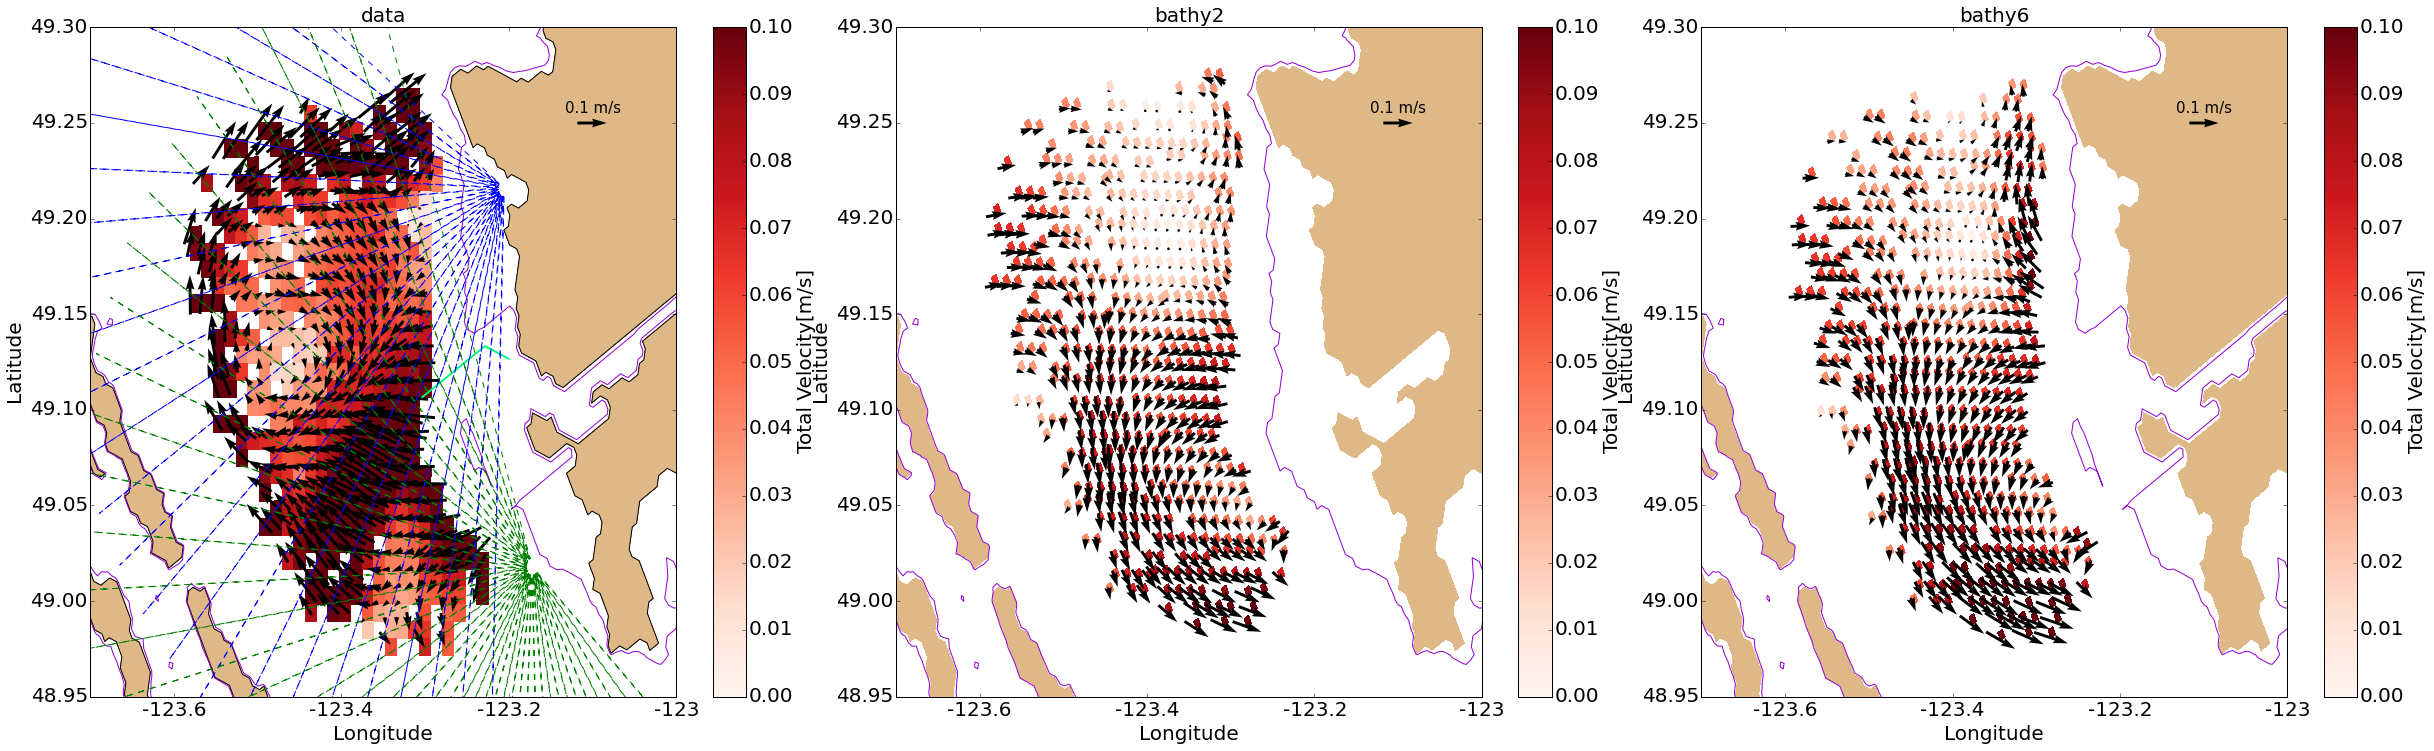

In [13]:
fig = plot_both(run_low,run_up)

* Looks to me there still exists convergence line, which seems to align with ilona radial grid. Compared with Rich's 2015 mean current, which still shows the convergence line, means it is robust.
* Anticyclonic gyre signal in the mean codar current, could be due to not long enough time to average, so that local wind affect this one month period, need to explore sensitivity of mean codar current to different time period and maybe worthwile plot the average wind stress.
* Note not all the surface current will carry fresh water, may also look at salinity.

#  U,V std

In [14]:
def mean_std(run_low,run_up):
    """This function is made to calculate mean u and v, std of u and v as well"""
    p_low, ind_low = codar.python_time(run_low,t); p_up, ind_up = codar.python_time(run_up,t)
    sta = np.zeros((46,36));
    for j in range(46):
        for i in range(36): ## count of nan
            sta[j,i] = 100*np.sum(np.isnan(u[j,i,ind_low:ind_up]))/(ind_up-ind_low)
    sta[sta<50] = 0 ##selet good data
    sta[sta>=50] = 1
    uu = np.ma.masked_array(u[:,:,0], sta)
    mask = uu.mask ## mask array
    ## mask is equal to mask array, broadcast here!
    mask_expand = np.expand_dims(mask, axis=2)
    mask_expand = mask_expand + np.zeros(u.shape) #broadcasting here!
    #Apply mask to whole
    u_mask = np.ma.masked_array(u,mask=mask_expand)
    v_mask = np.ma.masked_array(v,mask=mask_expand)
    ## mean
    u_new = np.nanmean(u_mask[:,:,ind_low:ind_up],axis = 2); ##average the whole time period in a month
    v_new = np.nanmean(v_mask[:,:,ind_low:ind_up],axis = 2)  
    ## std
    u_std = np.nanstd(np.copy(u_mask[:,:,ind_low:ind_up]), axis = 2)
    v_std = np.nanstd(np.copy(v_mask[:,:,ind_low:ind_up]), axis = 2)
    ## apply mask to std
    u_std = np.ma.masked_array(u_std,mask=mask)
    v_std = np.ma.masked_array(v_std,mask=mask)
    return u_new, v_new, u_std,v_std

In [15]:
u_new, v_new, u_std,v_std = mean_std(run_low,run_up)

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


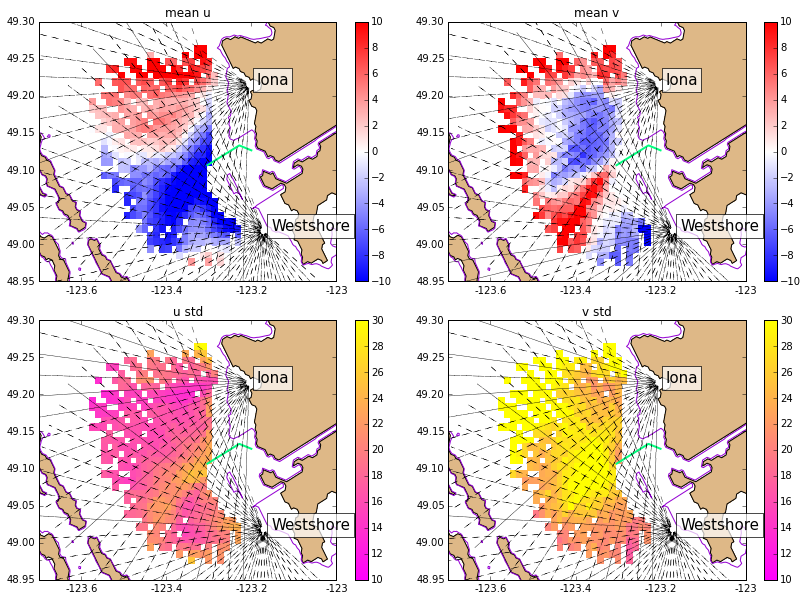

In [16]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(2, 2,width_ratios=[1, 1])  
gs.update(hspace=0.15, wspace=0.1)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1]); ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
cmin0 = -10; cmax0 = 10
cmin1 = 10; cmax1 = 30
titles = ['mean u', 'mean v', 'u std', 'v std']
names = ['Iona', 'Westshore']
for ax, title in zip([ax0,ax1,ax2,ax3],titles):
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='SpringGreen')
    ax.set_xlim([-123.7,-123])
    ax.set_ylim([48.95,49.3])
    ax.plot(iona_data['gridLon'],iona_data['gridLat'],'k--',linewidth = 0.4)
    ax.plot(west_data['gridLon'],west_data['gridLat'],'k--',linewidth = 0.4)
    for stn in names:
        ax.annotate(stn, (stations[stn]['lon']+0.02, stations[stn]['lat']), \
                        fontsize=15, color='black', bbox=bbox_args)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ax.set_title(title)
mesh=ax0.pcolormesh(lon_codar,lat_codar,u_new, cmap='bwr',  vmin=cmin0, vmax=cmax0)
cbar = plt.colorbar(mesh, ax=ax0)
mesh=ax1.pcolormesh(lon_codar,lat_codar,v_new, cmap='bwr',  vmin=cmin0, vmax=cmax0)
cbar = plt.colorbar(mesh, ax=ax1)
mesh=ax2.pcolormesh(lon_codar,lat_codar,u_std, cmap='spring',  vmin=cmin1, vmax=cmax1)
cbar = plt.colorbar(mesh, ax=ax2)
mesh=ax3.pcolormesh(lon_codar,lat_codar,v_std, cmap='spring',  vmin=cmin1, vmax=cmax1)
cbar = plt.colorbar(mesh, ax=ax3)

# Test different time period data

In [17]:
def test_period_data(run_low, run_up,cmin = 0, cmax = 0.1):
    """This function was made to test sensitivity of
     mean current to time period"""
    fig, ax0 = plt.subplots(1,1,figsize = (8,6))
    viz_tools.plot_coastline(ax0, grid6, coords = 'map')
    viz_tools.plot_coastline(ax0, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    viz_tools.plot_land_mask(ax0,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    ax0.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='SpringGreen')
    
    p_low, ind_low = codar.python_time(run_low,t); p_up, ind_up = codar.python_time(run_up,t)
    sta = np.zeros((46,36));
    for j in range(46):
        for i in range(36): ## count of nan
            sta[j,i] = 100*np.sum(np.isnan(u[j,i,ind_low:ind_up]))/(ind_up-ind_low)
    sta[sta<50] = 0 ##selet good data
    sta[sta>=50] = 1
    uu = np.ma.masked_array(u[:,:,0], sta)
    mask = uu.mask ## mask array
    ## mask is equal to mask array, broadcast here!
    mask_expand = np.expand_dims(mask, axis=2)
    mask_expand = mask_expand + np.zeros(u.shape) #broadcasting here!
    #Apply mask
    u_mask = np.ma.masked_array(u,mask=mask_expand)
    v_mask = np.ma.masked_array(v,mask=mask_expand)
    
    u_new = np.nanmean(u_mask[:,:,ind_low:ind_up]/100,axis = 2); ##average the whole time period in a month
    v_new = np.nanmean(v_mask[:,:,ind_low:ind_up]/100,axis = 2)
    ## plot codar
    mesh=ax0.pcolormesh(lon_codar,lat_codar, ma.masked_invalid(np.sqrt(u_new**2+v_new**2)), cmap='Reds', \
                        vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax0)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax0.quiver(lon_codar, lat_codar,u_new,v_new, pivot='mid', scale = 2,width=0.005, color='black')
    ax0.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s',coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    ax0.set_xlim([-123.7,-123])
    ax0.set_ylim([48.95,49.3])
    plt.setp(ax0.get_xticklabels(), fontsize=20)
    plt.setp(ax0.get_yticklabels(), fontsize=20)
    ax0.set_xticks([-123.6, -123.4, -123.2,-123])
    ax0.set_xticklabels([-123.6, -123.4, -123.2,-123])  
    ax0.set_title('mean current from '+ run_low.strftime('%d%b%y')+' to '+ run_up.strftime('%d%b%y'))
    plt.show()

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


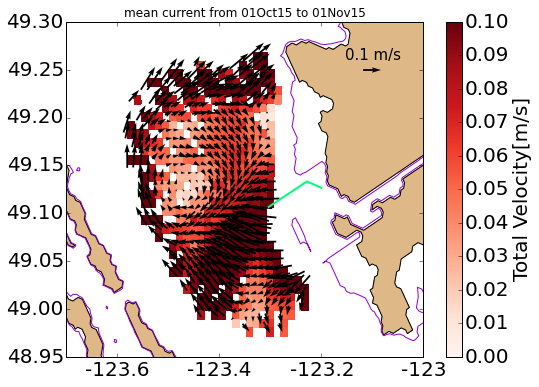

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


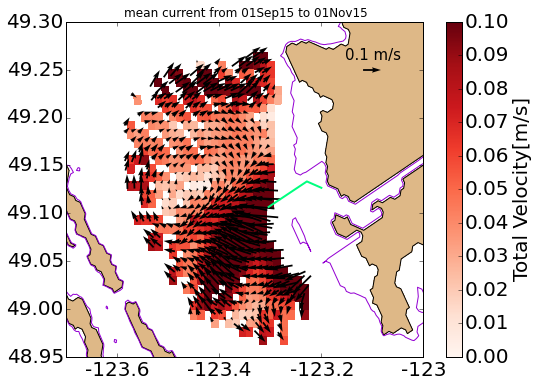

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


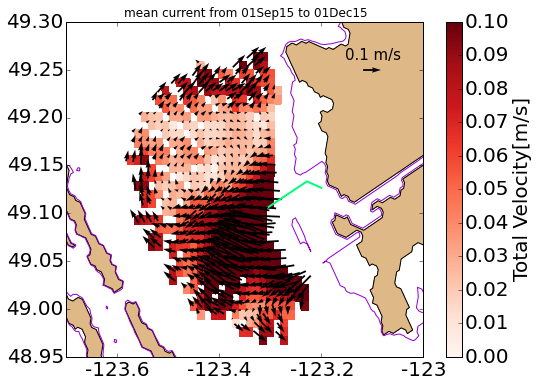

In [18]:
run_low = datetime.datetime(2015,10,1,0);
run_up = datetime.datetime(2015,11,1,0);
test_period_data(run_low, run_up)
run_low = datetime.datetime(2015,9,1,0);
run_up = datetime.datetime(2015,11,1,0);
test_period_data(run_low, run_up)
run_low = datetime.datetime(2015,9,1,0);
run_up = datetime.datetime(2015,12,1,0);
test_period_data(run_low, run_up)

# Explore the wind

* EC obs at sandheads

In [18]:
OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m10d01.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]

In [13]:
wind_speed = {}; wind_dir = {}; time = {}; lat={}; lon={}; press={}; temp={}; therm={};
solar={}; precip={}; qair={}

start = '1-Oct-2015'; end = '31-Oct-2015';
start2 = '31-Oct-2015'; end2 = '31-Oct-2015';

stations = ['Sandheads']

for key in stations:
    [wind_speed[key],wind_dir[key],temp[key],time[key], 
     lat[key], lon[key]] = stormtools.get_EC_observations(key,start,end)
    [ws,wd,T,t, la, lo] = stormtools.get_EC_observations(key,start2,end2)
    wind_speed[key]=np.append(wind_speed[key],ws)
    wind_dir[key]=np.append(wind_dir[key],wd)
    time[key]=np.append(time[key],t)
    temp[key]=np.append(temp[key],T)

In [14]:
def find_model_point(lon,lat,X,Y):
        # Tolerance for searching for grid points
    # (approx. distances between adjacent grid points)
    tol1 = 0.015 # lon
    tol2 = 0.015# lat

    # Search for a grid point with lon/lat within tolerance of
    # measured location
    x1, y1 = np.where(
        np.logical_and(
            (np.logical_and(X > lon-tol1, X < lon+tol1)),
            (np.logical_and(Y > lat-tol2, Y < lat+tol2))))
    return x1[0], y1[0]

* operational model wind

In [15]:
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m10d*.nc')
filesOP.sort(key=os.path.basename)

In [16]:
def compile_OP(j,i):
    wind=[]; direc=[]; t=[]; pr=[]; sol=[]; the=[]; pre=[]; tem=[]; qr=[];
    for f in filesOP:
        G = nc.Dataset(f)
        u = G.variables['u_wind'][0:24,j,i]; v=G.variables['v_wind'][0:24,j,i];
        pr.append(G.variables['atmpres'][0:24,j,i]); sol.append(G.variables['solar'][0:24,j,i]); 
        qr.append(G.variables['qair'][0:24,j,i]); the.append(G.variables['therm_rad'][0:24,j,i]); 
        pre.append(G.variables['precip'][0:24,j,i]); tem.append(G.variables['tair'][0:24,j,i])
        speed = np.sqrt(u**2 + v**2)
        wind.append(speed)
        
        d = np.arctan2(v, u)
        d = np.rad2deg(d + (d<0)*2*np.pi);
        direc.append(d)
        
        ts=G.variables['time_counter']
        torig = datetime.datetime(1970,1,1) #there is no time_origin attriubte in OP files, so I hard coded this
        for ind in np.arange(24):
            t.append((torig + datetime.timedelta(seconds=ts[ind])))
    
    wind = np.array(wind).reshape(len(filesOP)*24,)
    direc = np.array(direc,'double').reshape(len(filesOP)*24,)
    t = np.array(t).reshape(len(filesOP)*24,)
    pr= np.array(pr).reshape(len(filesOP)*24,)
    tem = np.array(tem).reshape(len(filesOP)*24,)
    sol = np.array(sol).reshape(len(filesOP)*24,)
    the = np.array(the).reshape(len(filesOP)*24,)
    qr = np.array(qr).reshape(len(filesOP)*24,)
    pre = np.array(pre).reshape(len(filesOP)*24,)
    
    return wind, direc, t, pr, tem, sol, the, qr, pre

In [19]:
stationsOP =['Sandheads_OP']

for (obs, modOP) in zip(stations,stationsOP):    
    [j,i]=find_model_point(lon[obs],lat[obs],OPlon,OPlat)
    lon[modOP] = OPlon[j,i]
    lat[modOP]=OPlat[j,i]

    [wind_speed[modOP],wind_dir[modOP],time[modOP],
     press[modOP],temp[modOP],solar[modOP],
     therm[modOP],qair[modOP],precip[modOP]] = compile_OP(j,i)

In [20]:
def compare_winds(duration,key1,key2,sax,eax,day,hour,minute):
    #compare wind speed and direction for data indicated by key1 and key2
    #time limits on axis given by sax,eax, label the duration range of 
    #drifter and particle floats.
    
    diff = 24 - hour
    hour2 = duration - diff
    day2 = day +1
    
    fig,axs = plt.subplots(2,1,figsize=(20,8))

    for key in [key1,key2]:
        ax=axs[0]
        ax.plot(time[key],wind_speed[key],label=key)
        ax.set_title('Wind speed')
        ax.set_xlim([sax,eax])
        ax.legend(loc=0)
        ax.set_ylabel('wind speed (m/s)')        
    
        ax=axs[1]
        ax.plot(time[key],wind_dir[key],label=key)
        ax.set_title('Wind direction')
        ax.set_xlim([sax,eax])
        ax.legend(loc=0)
        ax.set_ylabel('wind direction (degrees CCW from East)')
    ax=axs[0]
    t =datetime.datetime(2015, 10, day, hour, minute)
    tt=datetime.datetime(2015,10, day2, hour2, minute)
    ax.legend(loc=0)
    
    ax=axs[1]
    t =datetime.datetime(2015, 10, day, hour, minute)
    tt=datetime.datetime(2015,10, day2, hour2, minute)
    ax.legend(loc=0)
    
    fig,ax = plt.subplots(1,1,figsize=(5,6))
    for key in [key1,key2]:
        ax.plot(lon[key],lat[key],'o',label=key)
        viz_tools.plot_coastline(ax,grid,coords='map')
        ax.legend(loc='best')
        
    return ax

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


(49, 50)

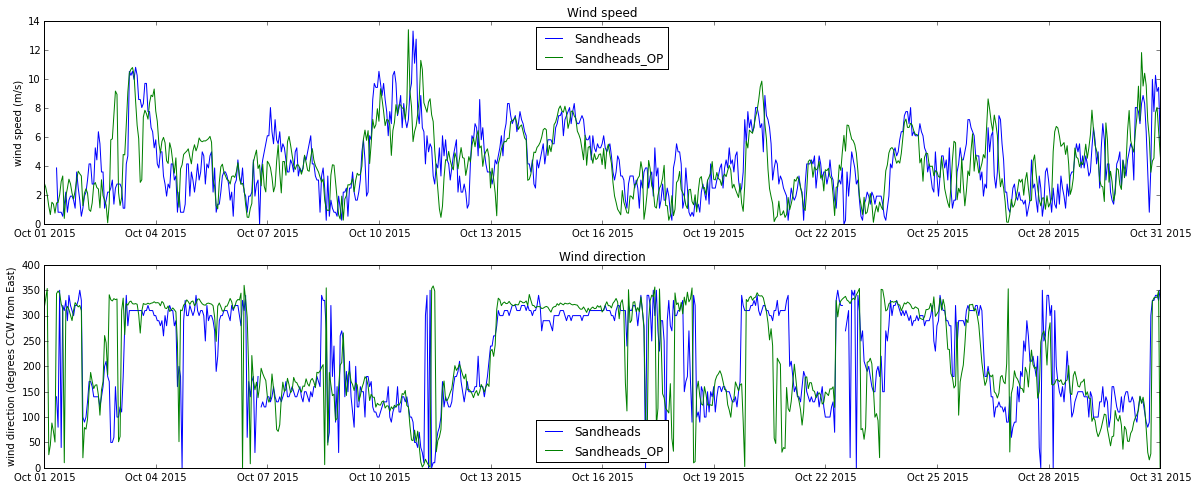

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


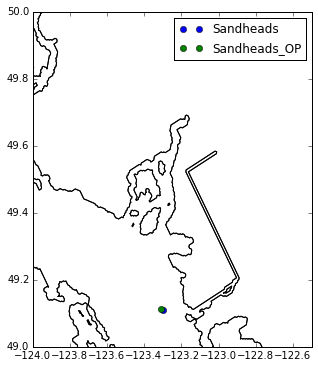

In [21]:
endd = '31-Oct-2015';
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

ax =compare_winds(27,'Sandheads','Sandheads_OP',sax,eax,8, 16, 0)
ax.set_xlim([-124,-122.5])
ax.set_ylim([49,50])

# Test of mask array for model result

In [12]:
p_low, ind_low = codar.python_time(run_low,t); p_up, ind_up = codar.python_time(run_up,t)
sta = np.zeros((46,36));
for j in range(46):
    for i in range(36): ## count of nan
        sta[j,i] = 100*np.sum(np.isnan(u[j,i,ind_low:ind_up]))/(ind_up-ind_low)
sta[sta<50] = 0 ##selet good data
sta[sta>=50] = 1
uu = np.ma.masked_array(u[:,:,0], sta)
mask = uu.mask ## mask array
## mask is equal to mask array, broadcast here!
mask_expand = np.expand_dims(mask, axis=2)
mask_expand = mask_expand + np.zeros(u.shape) #broadcasting here!
#Apply mask
u_mask = np.ma.masked_array(u,mask=mask_expand)
v_mask = np.ma.masked_array(v,mask=mask_expand)
    
u_new = np.nanmean(u_mask[:,:,ind_low:ind_up]/100,axis = 2); ##average the whole time period in a month
v_new = np.nanmean(v_mask[:,:,ind_low:ind_up]/100,axis = 2)
mm = ma.masked_invalid(np.sqrt(u_new**2+v_new**2))

In [13]:
u_grid = nc.Dataset('mean_U.nc','r'); v_grid = nc.Dataset('mean_V.nc','r'); 
u_m = {};v_m = {};U_m ={};V_m={};

u_m[grid2] =u_grid.variables['vozocrtx'][0, 0,jst-1:jen,ist-1:ien]
v_m[grid2] =v_grid.variables['vomecrty'][0, 0,jst-1:jen,ist-1:ien]
##unstagger u v
U_m[grid2],V_m[grid2] = viz_tools.unstagger(u_m[grid2],v_m[grid2])
#rotate
theta = np.pi*29/180
U_m[grid2] = U_m[grid2]*np.cos(theta) - V_m[grid2]*np.sin(theta)
V_m[grid2] = U_m[grid2]*np.sin(theta) +V_m[grid2]*np.cos(theta)
 ##mask
U_m[grid2]=np.ma.masked_values(U_m[grid2],0)
V_m[grid2]=np.ma.masked_values(V_m[grid2],0)

In [14]:
i_inds = [] ## indices to apply for model results
j_inds = []
for j in range(46):
    for i in range(36):
        if mm[j,i] != 1e+20:
            [jj,ii] = tidetools.find_closest_model_point(lon_codar[j,i],lat_codar[j,i],X[grid2],Y[grid2],bathy[grid2],\
                                                         lat_tol=0.0021)
            #print (jj,ii)
            j_inds.append(jj)
            i_inds.append(ii)
jj = np.array(j_inds)
ii = np.array(i_inds)

In [22]:
lon = X[grid2][jst:jen,ist:ien]
lat = Y[grid2][jst:jen,ist:ien]
U_m_new = np.copy(U_m[grid2])
U_m_new = ma.array(U_m_new, mask =True)
V_m_new = np.copy(V_m[grid2])
V_m_new = ma.array(V_m_new, mask =True)
for j in np.arange(480,380,-1):
    for i in np.arange(240,330,1):
        for k in range (len(jj)):
            if (j == jj[k]) and (i== ii[k]):
                #print('%s,%s,%s,%s,haha'%(j,i,jj[k],ii[k]))               
                U_m_new[j,i] = U_m[grid2][j,i]
                V_m_new[j,i] = V_m[grid2][j,i]

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


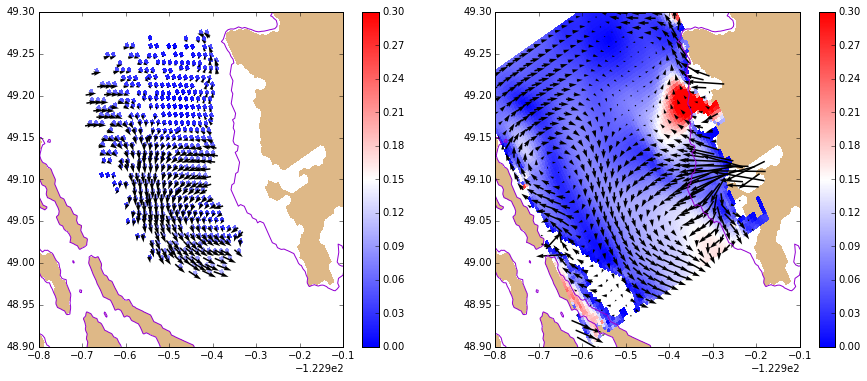

In [23]:
fig, axs = plt.subplots(1,2,figsize =[15,6])
for ax in axs:
    viz_tools.plot_land_mask(ax,grid2,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax, grid2, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.set_xlim([-123.7,-123])
    ax.set_ylim([48.9,49.3])
    
mesh=axs[0].pcolormesh(lon[400:480,240:320], lat[400:480,240:320]\
        ,np.sqrt(U_m_new[400:480,240:320]**2+V_m_new[400:480,240:320]**2),cmap='bwr', vmin=0, vmax=0.3)
cbar = plt.colorbar(mesh, ax=axs[0])
quiver = axs[0].quiver(lon[400:480,240:320], lat[400:480,240:320],U_m_new[400:480,240:320], V_m_new[400:480,240:320],\
                    pivot='mid',scale=2,width=0.005, color='black' ) 

mesh = axs[1].pcolormesh(lon[400:480,240:320], lat[400:480,240:320]\
            ,np.sqrt(U_m[grid2][380:460,240:320]**2+V_m[grid2][380:460,240:320]**2),cmap='bwr', vmin=0, vmax=0.3)
cbar = plt.colorbar(mesh, ax=axs[1])
quiver = axs[1].quiver(lon[400:480,240:320][::3,::3], lat[400:480,240:320][::3,::3],U_m[grid2][400:480,240:320][::3,::3], V_m[grid2][400:480,240:320][::3,::3],\
                    pivot='mid',scale=2,width=0.005, color='black' ) 

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


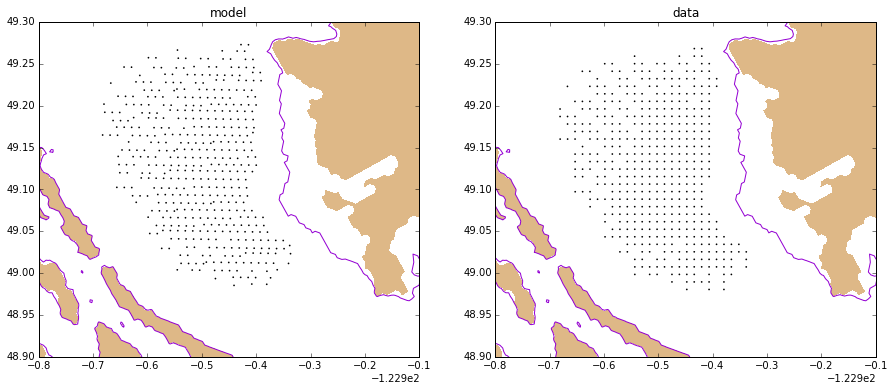

In [18]:
fig, axs = plt.subplots(1,2,figsize =[15,6])
for ax in axs:
    viz_tools.plot_land_mask(ax,grid2,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax, grid2, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.set_xlim([-123.7,-123])
    ax.set_ylim([48.9,49.3])
quiver = axs[0].quiver(lon[400:480,240:320], lat[400:480,240:320],U_m_new[400:480,240:320], V_m_new[400:480,240:320],\
                    pivot='mid',scale=2,width=0.005, color='black' ) #model 
axs[0].set_title('model')

for j in range(46):
    for i in range(36):
        if u_new[j,i]!= 1e+20:
            u_new[j,i] = 0
        if v_new[j,i]!= 1e+20:
            v_new[j,i] = 0 # data
quiver = axs[1].quiver(lon_codar, lat_codar,u_new,v_new, pivot='mid', scale = 2,width=0.005, color='black')
axs[1].set_title('data')

# Test domain of CODAR.nc to run model with bathy6

In [19]:
a = nc.Dataset('CODAR.nc')
alon = a.variables['nav_lon']
alat = a.variables['nav_lat']
au = a.variables['vozocrtx']

In [20]:
c = nc.Dataset('mean_U.nc')
cu = c.variables['vozocrtx']
clon = c.variables['nav_lon']
clat = c.variables['nav_lat']

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


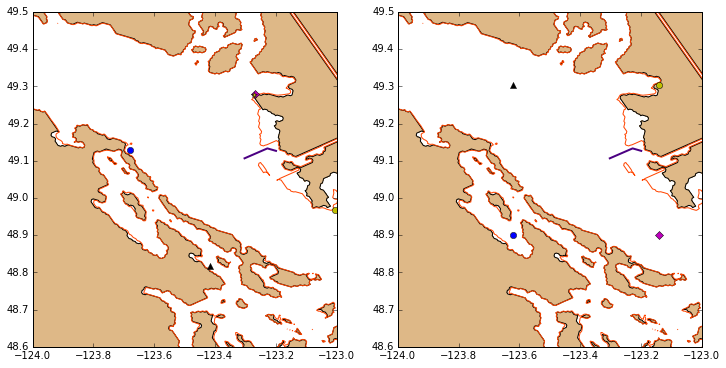

In [21]:
fig,axs = plt.subplots(1,2,figsize = (12,6))
##plot codar quiver
for ax in axs:
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
    viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    ax.set_xlim([-124,-123])
    ax.set_ylim([48.6,49.5])
axs[0].plot(alon[-1,0],alat[-1,0],'ob') ## (459,240)
axs[0].plot(alon[0,0],alat[0,0],'^k') ## (380, 240)
axs[0].plot(alon[0,-1],alat[0,-1],'oy') ##(380,319)
axs[0].plot(clon[459,319],clat[459,319],'mD') ## (459, 318)
axs[0].plot(alon[-1,-1],alat[-1,-1],'y*') ##(459, 319)
axs[1].plot(lon_codar[-1,0],lat_codar[-1,0],'ob')
axs[1].plot(lon_codar[0,0],lat_codar[0,0],'^k')
axs[1].plot(lon_codar[0,-1],lat_codar[0,-1],'oy')
axs[1].plot(lon_codar[-1,-1],lat_codar[-1,-1],'mD')